In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet
from prophet.plot import plot_plotly

%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("store_sales_data_clean_20240214.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    9800 non-null   int64  
 1   Order Date    9800 non-null   object 
 2   Segment       9800 non-null   object 
 3   Region        9800 non-null   object 
 4   Category      9800 non-null   object 
 5   Sub-Category  9800 non-null   object 
 6   Sales         9800 non-null   float64
 7   Day of Week   9800 non-null   int64  
 8   Day           9800 non-null   int64  
 9   Year          9800 non-null   int64  
 10  Month         9800 non-null   int64  
 11  Season        9800 non-null   object 
dtypes: float64(1), int64(5), object(6)
memory usage: 918.9+ KB


In [4]:
df.head()

,Unnamed: 0,Order Date,Segment,Region,Category,Sub-Category,Sales,Day of Week,Day,Year,Month,Season
0,0,2017-11-08,Consumer,South,Furniture,Bookcases,261.9600,2,8,2017,11,Autumn
1,1,2017-11-08,Consumer,South,Furniture,Chairs,731.9400,2,8,2017,11,Autumn
2,2,2017-06-12,Corporate,West,Office Supplies,Labels,14.6200,0,12,2017,6,Summer
3,3,2016-10-11,Consumer,South,Furniture,Tables,957.5775,1,11,2016,10,Autumn
4,4,2016-10-11,Consumer,South,Office Supplies,Storage,22.3680,1,11,2016,10,Autumn


In [5]:
# Group sales data by day, sort by Order Date
df_grouped = df.groupby('Order Date').agg({'Sales': 'sum'}).reset_index()
df_grouped = df_grouped.sort_values(by='Order Date', ascending=True)
df_grouped['Order Date'] = pd.to_datetime(df_grouped['Order Date'])



In [6]:
is_one_day_apart = (df_grouped['Order Date'].diff().dt.days == 1).all()

# Print the result
print("Dates are each one day apart:", is_one_day_apart)


Dates are each one day apart: False


In [7]:
# Set the 'Order Date' column as the index
df_grouped = df_grouped.set_index('Order Date')

# Create a new DataFrame with a daily frequency
daily_index = pd.date_range(start='2015-01-01', end='2018-12-31', freq='D')
df_daily = pd.DataFrame(index=daily_index)

# Merge the original DataFrame with the new DataFrame, filling missing values with 0
df_merged = df_daily.merge(df_grouped, how='left', left_index=True, right_index=True).fillna(0)

# Reset the index
df_merged = df_merged.reset_index()

# Rename the columns
df_merged = df_merged.rename(columns={'index': 'Order Date'})

# Print the result
print(df_merged)


     Order Date      Sales
0    2015-01-01     0.0000
1    2015-01-02     0.0000
2    2015-01-03    16.4480
3    2015-01-04   288.0600
4    2015-01-05    19.5360
...         ...        ...
1456 2018-12-27   177.6360
1457 2018-12-28  1657.3508
1458 2018-12-29  2915.5340
1459 2018-12-30   713.7900
1460 2018-12-31     0.0000

[1461 rows x 2 columns]


In [10]:
# Split data into train and test 
df_train = df_merged[:-365]
df_test = df_merged[-365:]


In [11]:
df_test

,Order Date,Sales
1096,2018-01-01,1481.8280
1097,2018-01-02,2079.5540
1098,2018-01-03,2070.2720
1099,2018-01-04,0.0000
1100,2018-01-05,0.0000
...,...,...
1456,2018-12-27,177.6360
1457,2018-12-28,1657.3508
1458,2018-12-29,2915.5340
1459,2018-12-30,713.7900


In [12]:
df_train

,Order Date,Sales
0,2015-01-01,0.000
1,2015-01-02,0.000
2,2015-01-03,16.448
3,2015-01-04,288.060
4,2015-01-05,19.536
...,...,...
1091,2017-12-27,959.490
1092,2017-12-28,0.000
1093,2017-12-29,1277.680
1094,2017-12-30,773.774


In [13]:
# Set Order Date as datetime 
df_train['Order Date'] = pd.to_datetime(df_train['Order Date'])

# Set ORder date as datetime in test set
df_test['Order Date'] = pd.to_datetime(df_test['Order Date'])

C:\Users\zive9\AppData\Local\Temp\ipykernel_19028\3033410643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Order Date'] = pd.to_datetime(df_train['Order Date'])
C:\Users\zive9\AppData\Local\Temp\ipykernel_19028\3033410643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Order Date'] = pd.to_datetime(df_test['Order Date'])


In [14]:
print("Train: ", df_train.shape)
print("Test: ", df_test.shape)

Train:  (1096, 2)
Test:  (365, 2)


## Model 1 - Simple Moving Average

In [15]:
df_sma = df_train.copy()

df_sma['SMA 10'] = df_train['Sales'].rolling(window=10).mean()
df_sma['SMA 30'] = df_train['Sales'].rolling(window=30).mean()
df_sma['SMA 90'] = df_train['Sales'].rolling(window=90).mean()
df_sma['SMA 180'] = df_train['Sales'].rolling(window=180).mean()
df_sma['SMA 365'] = df_train['Sales'].rolling(window=365).mean()
df_sma['Order Date'] = pd.to_datetime(df_train['Order Date']) 


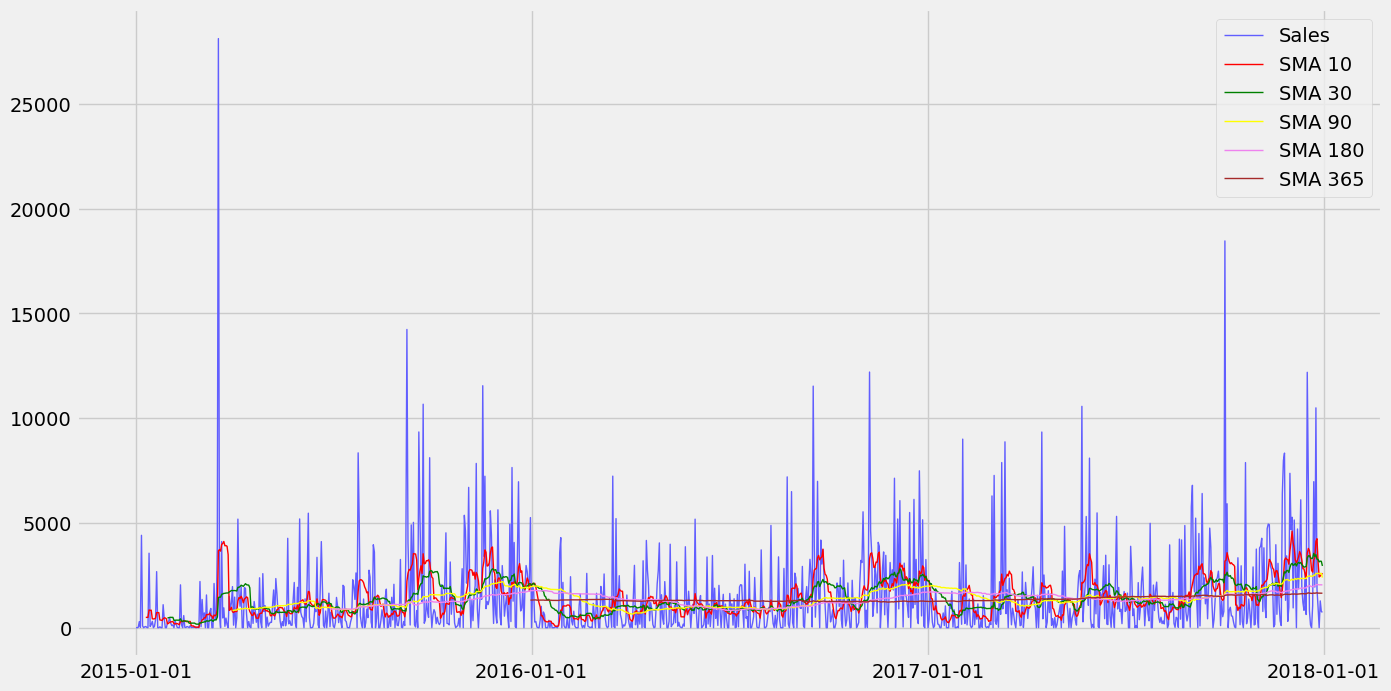

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [16]:
plt.figure(figsize=(15, 8))

plt.plot(df_sma['Order Date'], df_sma['Sales'], color='#615eff', label='Sales', linewidth=1)
plt.plot(df_sma['Order Date'], df_sma['SMA 10'], color='red', label='SMA 10', linewidth=1)
plt.plot(df_sma['Order Date'], df_sma['SMA 30'], color='green', label='SMA 30', linewidth=1)
plt.plot(df_sma['Order Date'], df_sma['SMA 90'], color='yellow', label='SMA 90', linewidth=1)
plt.plot(df_sma['Order Date'], df_sma['SMA 180'], color='violet', label='SMA 180', linewidth=1)
plt.plot(df_sma['Order Date'], df_sma['SMA 365'], color='brown', label='SMA 365', linewidth=1)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-01-01'))

plt.legend()
plt.show()
plt.figure(figsize=(15, 8))



### Forecast sales

In [17]:
# Forecasts for the period 2018-01-01 to 2018-01-31

print("10 Day SMA Forecast: ", sum(df_sma['SMA 10'].iloc[-365:]))
print("30 Day SMA Forecast: ", sum(df_sma['SMA 30'].iloc[-365:]))
print("90 Day SMA Forecast: ", sum(df_sma['SMA 90'].iloc[-365:]))
print("180 Day SMA Forecast: ", sum(df_sma['SMA 180'].iloc[-365:]))
print("365 Day SMA Forecast: ", sum(df_sma['SMA 365'].iloc[-365:]))

10 Day SMA Forecast:  602046.8523999997
30 Day SMA Forecast:  594637.1769000002
90 Day SMA Forecast:  579017.636383333
180 Day SMA Forecast:  563099.6047944445
365 Day SMA Forecast:  527259.0907484933


In [18]:
# RMSE 
print("10 Day SMA RMSE: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 10'].iloc[-365:])))
print("30 Day SMA RMSE: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 30'].iloc[-365:])))
print("90 Day SMA RMSE: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 90'].iloc[-365:])))
print("180 Day SMA RMSE: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 180'].iloc[-365:])))
print("365 Day SMA RMSE: ", np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 365'].iloc[-365:])))

10 Day SMA RMSE:  2399.5922310575315
30 Day SMA RMSE:  2336.1972034507453
90 Day SMA RMSE:  2363.6534031552483
180 Day SMA RMSE:  2392.658843698943
365 Day SMA RMSE:  2391.1377234814004


In [76]:
# MAE
print("10 Day SMA MAE: ", (mean_absolute_error(df_test['Sales'], df_sma['SMA 10'].iloc[-365:])))
print("30 Day SMA MAE: ", (mean_absolute_error(df_test['Sales'], df_sma['SMA 30'].iloc[-365:])))
print("90 Day SMA MAE: ", (mean_absolute_error(df_test['Sales'], df_sma['SMA 90'].iloc[-365:])))
print("180 Day SMA MAE: ", (mean_absolute_error(df_test['Sales'], df_sma['SMA 180'].iloc[-365:])))
print("365 Day SMA MAE: ", (mean_absolute_error(df_test['Sales'], df_sma['SMA 365'].iloc[-365:])))

10 Day SMA MAE:  1640.6025448767125
30 Day SMA MAE:  1569.4407505388126
90 Day SMA MAE:  1579.5157071689498
180 Day SMA MAE:  1601.9059016529682
365 Day SMA MAE:  1561.1635480352786


When forecasting a year, the best window for SMA forecast is 30 days. 

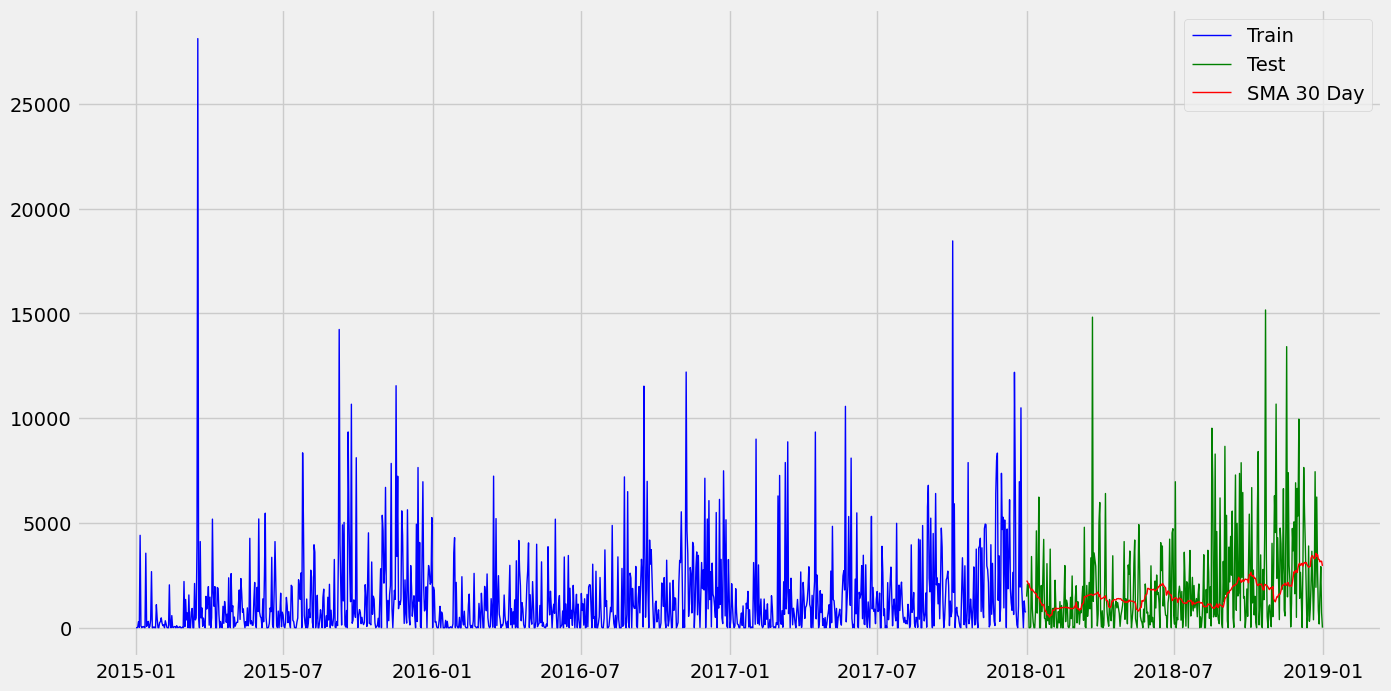

In [20]:
# Plot the SAM 30 Day forecast and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], df_sma['SMA 30'].iloc[-365:], label='SMA 30 Day', color='red', linewidth=1)
plt.legend()
plt.show()

## Model 2 - ARIMA

In [21]:
# Format the data
df_arima_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
df_arima_train = df_arima_train.asfreq('D')

# Grid search to find the best parameters for ARIMA model
p = range(0, 4)  # Example: considering 0, 1, 2, 3
d = range(0, 4)  # Example: considering 0, 1, 2, 3
q = range(0, 4)  # Example: considering 0, 1, 2, 3

pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(df_arima_train, order=param)
        results = model.fit()

        # Compare this model's AIC to the best (lowest) AIC found so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:  # Catch and ignore exceptions caused by unfit model specifications
        continue

print(f"Best ARIMA{best_pdq}\n\n Best AIC: {best_aic}")


c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\zive9\anaconda3\env

Best ARIMA(2, 1, 3)

 Best AIC: 19848.57093940642


c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecast

In [22]:
arima = ARIMA(df_arima_train, order=best_pdq)
arima_fit = arima.fit()

forecast_arima = arima_fit.forecast(steps=365)
forecast_arima

c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2018-01-01    2659.968055
2018-01-02    3287.542032
2018-01-03    2519.086811
2018-01-04    2237.061456
2018-01-05    3129.714507
                 ...     
2018-12-27    2567.590302
2018-12-28    3068.118948
2018-12-29    2709.419519
2018-12-30    2370.730471
2018-12-31    2880.060816
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [26]:
# RMSE
arima_rmse = np.sqrt(mean_squared_error(df_test['Sales'], forecast_arima))
print("ARIMA RMSE: ", np.sqrt(mean_squared_error(df_test['Sales'], forecast_arima)))

ARIMA RMSE:  2435.448395756849


In [78]:
# MAE
arima_mae = (mean_absolute_error(df_test['Sales'], forecast_arima))
print("ARIMA MAE: ", (mean_absolute_error(df_test['Sales'], forecast_arima)))

ARIMA MAE:  1971.1171502681225


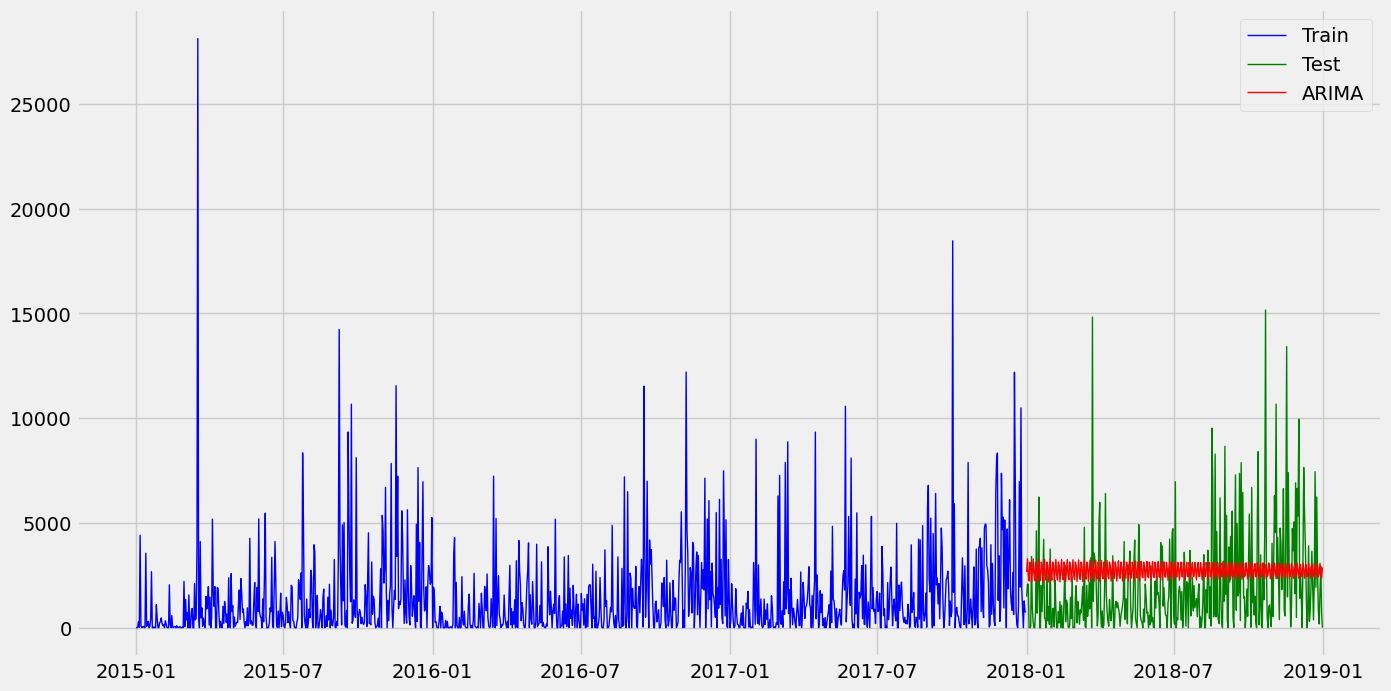

In [28]:
# Plot the ARIMA forecast and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], forecast_arima, label='ARIMA', color='red', linewidth=1)
plt.legend()
plt.show()


## SARIMA Daily

# Trying SARIMA with the daily data 

# Format the data
# df_sm_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
# df_sm_train = df_sm_train.resample('M').sum()
# df_sm_test = df_test[['Order Date', 'Sales']].set_index('Order Date')
# df_sm_test = df_sm_test.resample('M').sum()

df_sm_daily_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
df_sm_daily_test = df_test[['Order Date', 'Sales']].set_index('Order Date')

# Grid search to find the best parameters for SARIMA model
# p = range(0, 2)  # Example: considering 0, 1, 2
# d = range(0, 2)  # Example: considering 0, 1, 2
# q = range(0, 2)  # Example: considering 0, 1, 2

# P = range(0, 2)
# D = range(0, 2)
# Q = range(0, 2)
# S = [365]

# param_combinations = list(itertools.product(p, d, q, P, D, Q, S))

# best_aic = np.inf
# best_params = None

# for params in param_combinations:
#     try:
#         sm = SARIMAX(df_sm_daily_train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
#         results = sm.fit(disp=False)
        
#         if results.aic < best_aic:
#             best_aic = results.aic
#             best_params = params
#     except:
#         continue

# print(f"Best AIC: {best_aic}")
# print(f"Best Parameters: {best_params}")

### Forecast

# SARIMA daily grid search is very slow, so taking params from ARIMA
inf_params = (2, 2, 2, 2, 2, 2, 365)

sm_daily = SARIMAX(df_sm_daily_train, order=inf_params[:3], seasonal_order=inf_params[3:], enforce_stationarity=False, enforce_invertibility=False)
sm_daily_fit = sm_daily.fit()

forecast_sarima_daily = sm_daily_fit.forecast(steps=30)
forecast_sarima_daily

# RMSE
error_sarima_daily = np.sqrt(mean_squared_error(df_sm_daily_test['Sales'], forecast_sarima_daily))
print("SARIMA Daily Error: ", np.sqrt(mean_squared_error(df_sm_daily_test['Sales'], forecast_sarima_daily)))

## Model 3 - SARIMA, monthly

# Because SARIMAX is slow to compute, we will group by month instead of day

# Format the data
df_sm_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
df_sm_train = df_sm_train.resample('M').sum()
df_sm_test = df_test[['Order Date', 'Sales']].set_index('Order Date')
df_sm_test = df_sm_test.resample('M').sum()

# Grid search to find the best parameters for SARIMA model
p = range(0, 3)  # Example: considering 0, 1, 2
d = range(0, 3)  # Example: considering 0, 1, 2
q = range(0, 3)  # Example: considering 0, 1, 2

P = range(0, 3)
D = range(0, 3)
Q = range(0, 3)
S = [12]

param_combinations = list(itertools.product(p, d, q, P, D, Q, S))

best_aic = np.inf
best_params = None

for params in param_combinations:
    try:
        sm = SARIMAX(df_sm_train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
        results = sm.fit(disp=False)
        
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
    except:
        continue

print(f"Best AIC: {best_aic}")
print(f"Best Parameters: {best_params}")




### Forecast

sm = SARIMAX(df_sm_train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
sm_fit = sm.fit()

forecast_sarima = sm_fit.forecast(steps=1)
forecast_sarima

# RMSE
error_sarima = np.sqrt(mean_squared_error(df_sm_test['Sales'], forecast_sarima))
print("SARIMAX Error: ", np.sqrt(mean_squared_error(df_sm_test['Sales'], forecast_sarima)))

## Model 4 - Prophet model

In [29]:
#Format the training and test data for Prophet
df_pt_train = df_train[['Order Date', 'Sales']]
df_pt_train = df_pt_train.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

df_pt_test = df_test[['Order Date', 'Sales']]
df_pt_test = df_pt_test.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

In [30]:
# Instantiate the Prophet model
pt = Prophet()

pt_fit = pt.fit(df_pt_train)

14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing


### Forecast

In [31]:
future = pt_fit.make_future_dataframe(periods=365)

forecast_pt = pt_fit.predict(future)
forecast_pt

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,1246.549719,-1884.812042,3138.572133,1246.549719,1246.549719,-629.597300,-629.597300,-629.597300,-643.313261,-643.313261,-643.313261,13.715962,13.715962,13.715962,0.0,0.0,0.0,616.952419
1,2015-01-02,1246.669885,-2314.174572,2666.634935,1246.669885,1246.669885,-844.040435,-844.040435,-844.040435,-716.063467,-716.063467,-716.063467,-127.976967,-127.976967,-127.976967,0.0,0.0,0.0,402.629450
2,2015-01-03,1246.790051,-1278.410912,3679.188050,1246.790051,1246.790051,103.653686,103.653686,103.653686,371.131161,371.131161,371.131161,-267.477475,-267.477475,-267.477475,0.0,0.0,0.0,1350.443738
3,2015-01-04,1246.910218,-1542.618594,3599.800205,1246.910218,1246.910218,-201.567019,-201.567019,-201.567019,201.062457,201.062457,201.062457,-402.629476,-402.629476,-402.629476,0.0,0.0,0.0,1045.343199
4,2015-01-05,1247.030384,-1774.415477,3220.768202,1247.030384,1247.030384,-480.987440,-480.987440,-480.987440,50.360794,50.360794,50.360794,-531.348235,-531.348235,-531.348235,0.0,0.0,0.0,766.042944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2018-12-27,2075.887196,-343.323847,4494.714111,2045.909022,2105.437489,37.609108,37.609108,37.609108,-643.313261,-643.313261,-643.313261,680.922369,680.922369,680.922369,0.0,0.0,0.0,2113.496304
1457,2018-12-28,2076.748281,-465.813065,4374.867654,2046.671171,2106.429663,-156.454347,-156.454347,-156.454347,-716.063467,-716.063467,-716.063467,559.609120,559.609120,559.609120,0.0,0.0,0.0,1920.293933
1458,2018-12-29,2077.609365,435.601881,5497.738805,2047.435711,2107.421838,801.508104,801.508104,801.508104,371.131161,371.131161,371.131161,430.376943,430.376943,430.376943,0.0,0.0,0.0,2879.117470
1459,2018-12-30,2078.470450,-44.063975,5226.885417,2048.200250,2108.448053,496.063374,496.063374,496.063374,201.062457,201.062457,201.062457,295.000917,295.000917,295.000917,0.0,0.0,0.0,2574.533824


In [32]:
# Absolute error 
forecast_pt_sum = forecast_pt['yhat'].iloc[-365:].sum()

df_pt_test_sum = df_pt_test['y'].sum() 

diff = abs(forecast_pt_sum - df_pt_test_sum)

pt_error_pct = (diff / df_pt_test_sum) * 100
pt_error_pct

2.8064805565614814

In [33]:
# RMSE
pt_rmse = np.sqrt(mean_squared_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-365:]))
print("Prophet Error: ", pt_rmse)

Prophet Error:  2245.226596094206


In [34]:
# Mean Absolute Error
pt_mae = mean_absolute_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-365:])
pt_mae

1572.6162139152857

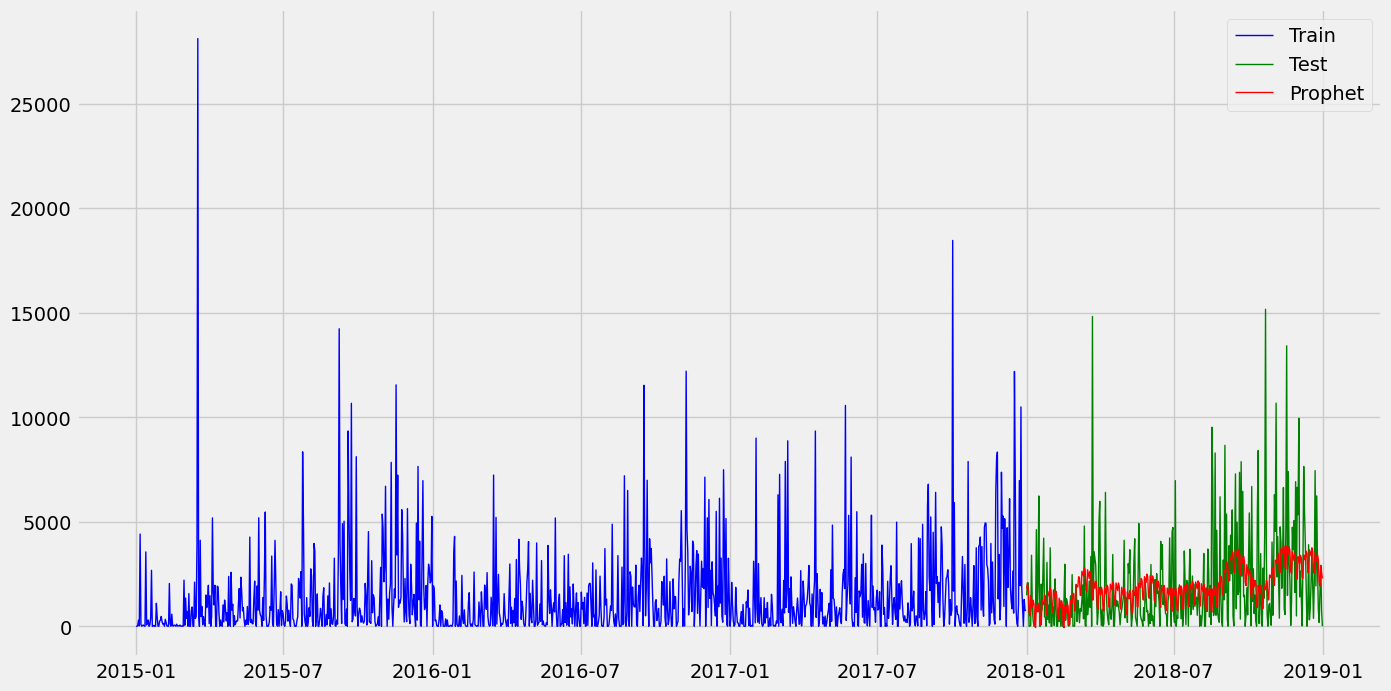

In [35]:
# Plot the Prophet forecast and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], forecast_pt[-365:]['yhat'], label='Prophet', color='red', linewidth=1)
plt.legend()
plt.show()

## Model 4.5  Prophet with differencing 

In [36]:
#Format the training and test data for Prophet
df_pt_train = df_train[['Order Date', 'Sales']]
df_pt_train = df_pt_train.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

df_pt_test = df_test[['Order Date', 'Sales']]
df_pt_test = df_pt_test.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

In [37]:
df_pt_train.head()

,ds,y
0,2015-01-01,0.000
1,2015-01-02,0.000
2,2015-01-03,16.448
3,2015-01-04,288.060
4,2015-01-05,19.536


In [38]:
# Check for stationarity 

from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary.")
    else:
        print("Weak evidence against null hypothesis, fail to reject the null hypothesis. Data is non-stationary.")

adfuller_test(df_pt_train['y'])

ADF Test Statistic : -5.623359660999743
p-value : 1.131831387903464e-06
#Lags Used : 15
Number of Observations : 1080
Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary.


Although the data is stationary, let's difference it to see if we can get a better result. 

In [39]:
# Difference the time series data 
df_pt_train['First diff'] = df_pt_train['y'].diff(periods=1)
df_pt_train.head()

,ds,y,First diff
0,2015-01-01,0.000,NaN
1,2015-01-02,0.000,0.000
2,2015-01-03,16.448,16.448
3,2015-01-04,288.060,271.612
4,2015-01-05,19.536,-268.524


In [40]:
# Check differenced series for stationarity 

from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary.")
    else:
        print("Weak evidence against null hypothesis, fail to reject the null hypothesis. Data is non-stationary.")

adfuller_test(df_pt_train['First diff'].dropna())

ADF Test Statistic : -12.472646673960854
p-value : 3.21928693559394e-23
#Lags Used : 19
Number of Observations : 1075
Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary.


In [41]:
# Get the data ready 

df_pt_diff_train = df_pt_train[['ds', 'First diff']].fillna(0)
df_pt_diff_train = df_pt_diff_train.rename(columns={'First diff': 'y'})

In [42]:
# Instantiate the Prophet model

pt_diff = Prophet()

pt_diff_fit = pt_diff.fit(df_pt_diff_train)

14:56:22 - cmdstanpy - INFO - Chain [1] start processing
14:56:22 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Forecast 
future = pt_diff_fit.make_future_dataframe(periods=365)

forecast_diff_pt = pt_diff_fit.predict(future)
forecast_diff_pt

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,17.960296,-4671.004411,2625.396112,17.960296,17.960296,-1069.919257,-1069.919257,-1069.919257,-933.900284,-933.900284,-933.900284,-136.018973,-136.018973,-136.018973,0.0,0.0,0.0,-1051.958961
1,2015-01-02,17.929734,-3723.576932,3201.776042,17.929734,17.929734,-209.806073,-209.806073,-209.806073,-73.182471,-73.182471,-73.182471,-136.623603,-136.623603,-136.623603,0.0,0.0,0.0,-191.876339
2,2015-01-03,17.899172,-2521.162050,4434.242435,17.899172,17.899172,953.176133,953.176133,953.176133,1088.284658,1088.284658,1088.284658,-135.108525,-135.108525,-135.108525,0.0,0.0,0.0,971.075305
3,2015-01-04,17.868610,-3854.518269,3358.675679,17.868610,17.868610,-302.055747,-302.055747,-302.055747,-170.570138,-170.570138,-170.570138,-131.485608,-131.485608,-131.485608,0.0,0.0,0.0,-284.187137
4,2015-01-05,17.838048,-3895.337139,3173.069529,17.838048,17.838048,-285.726881,-285.726881,-285.726881,-159.910577,-159.910577,-159.910577,-125.816304,-125.816304,-125.816304,0.0,0.0,0.0,-267.888833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2018-12-27,-26.480298,-4702.496150,2394.979314,-26.483008,-26.477905,-1038.024229,-1038.024229,-1038.024229,-933.900284,-933.900284,-933.900284,-104.123945,-104.123945,-104.123945,0.0,0.0,0.0,-1064.504527
1457,2018-12-28,-26.510810,-3594.617449,3399.075939,-26.513534,-26.508401,-187.036388,-187.036388,-187.036388,-73.182471,-73.182471,-73.182471,-113.853917,-113.853917,-113.853917,0.0,0.0,0.0,-213.547198
1458,2018-12-29,-26.541321,-2546.057926,4448.903784,-26.544059,-26.538898,966.186358,966.186358,966.186358,1088.284658,1088.284658,1088.284658,-122.098300,-122.098300,-122.098300,0.0,0.0,0.0,939.645037
1459,2018-12-30,-26.571832,-3784.324778,3350.227463,-26.574585,-26.569395,-299.218508,-299.218508,-299.218508,-170.570138,-170.570138,-170.570138,-128.648370,-128.648370,-128.648370,0.0,0.0,0.0,-325.790340


In [44]:
# RMSE for differenced data
pt_diff_rmse = np.sqrt(mean_squared_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-365:]))
print("Prophet Error: ", pt_diff_rmse)

Prophet Error:  2245.226596094206


In [45]:
# Mean Absolute Error for differenced data
pt_diff_mae = mean_absolute_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-365:])
pt_diff_mae

1572.6162139152857

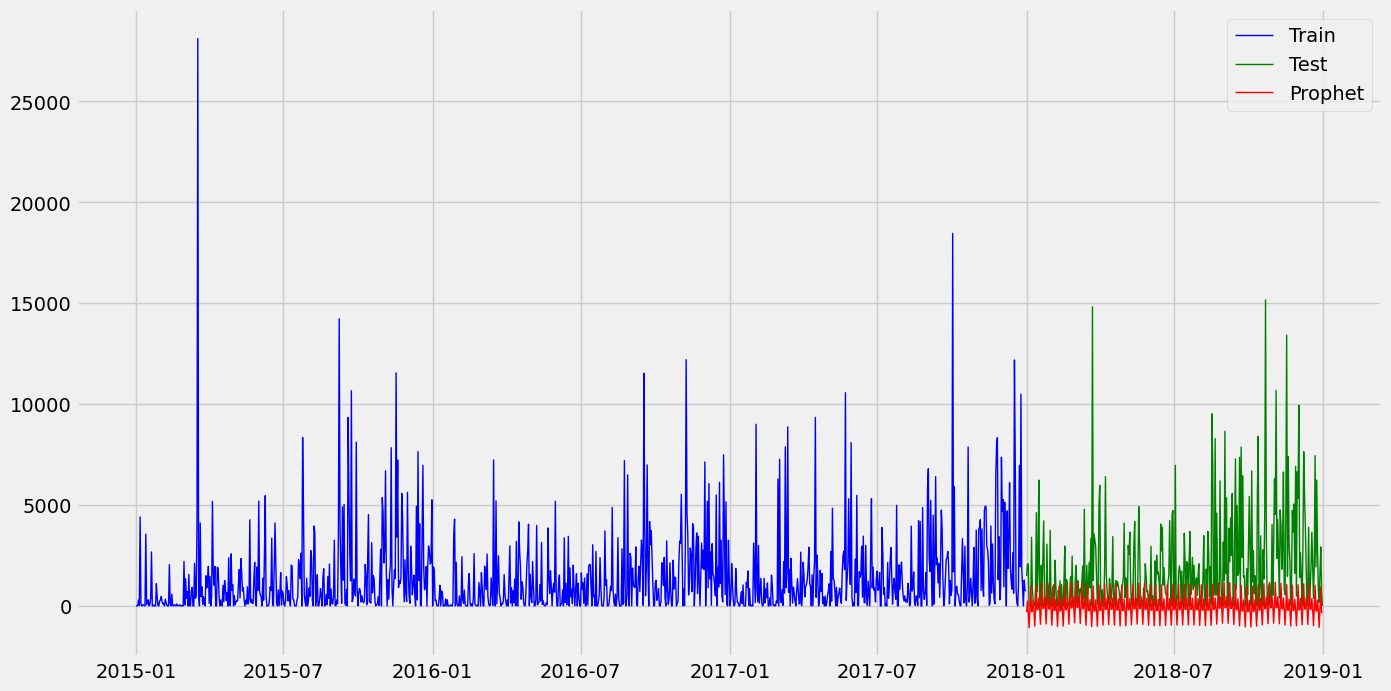

In [46]:
# Plot the differenced Prophet forecast and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], forecast_diff_pt[-365:]['yhat'], label='Prophet', color='red', linewidth=1)
plt.legend()
plt.show()

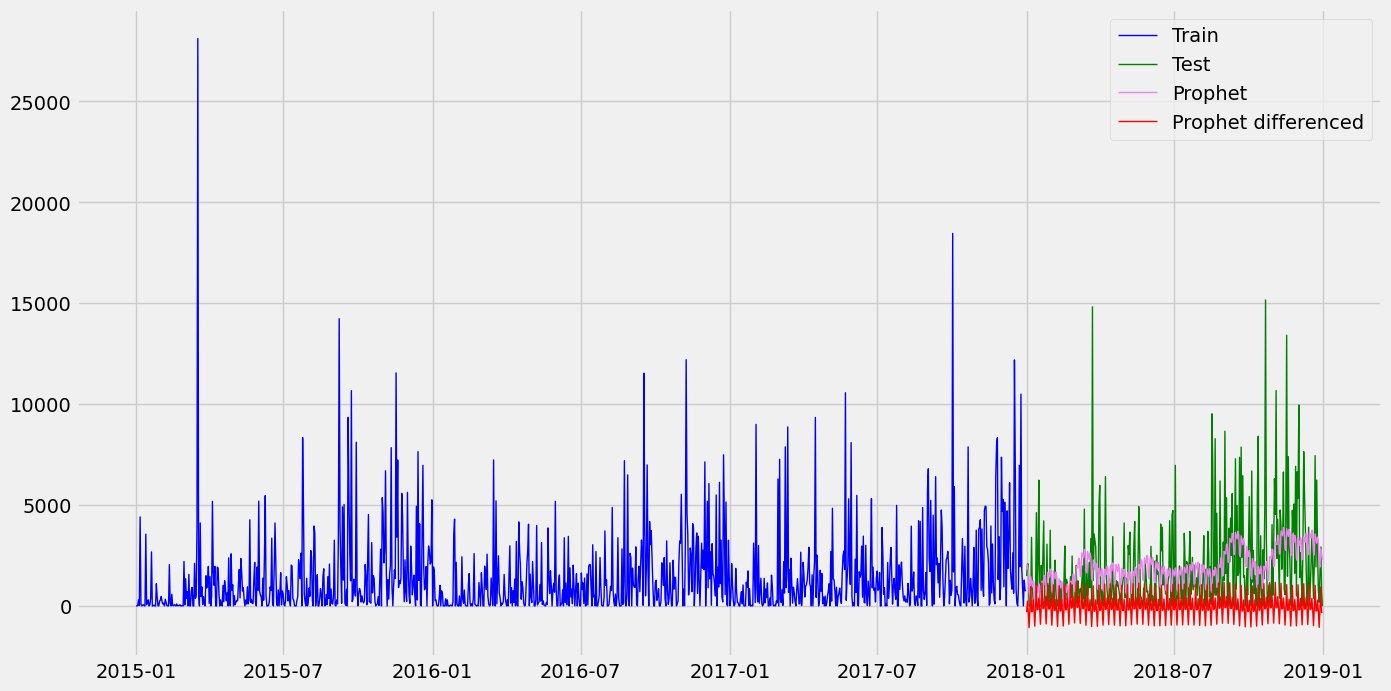

In [40]:
# Compare the standard data vs the differenced data for Prophet 
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], forecast_pt[-365:]['yhat'], label='Prophet', color='violet', linewidth=1)
plt.plot(df_test['Order Date'], forecast_diff_pt[-365:]['yhat'], label='Prophet differenced', color='red', linewidth=1)
plt.legend()
plt.show()

## Model 5 - VAR

In [47]:
# We need to check if the categorical variables can be one hot encoded 
print(df['Category'].value_counts())
print("\n", df['Sub-Category'].value_counts())
print("\n", df['Region'].value_counts())
print("\n", df['Segment'].value_counts())

Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64

 Sub-Category
Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: count, dtype: int64

 Region
West       3140
East       2785
Central    2277
South      1598
Name: count, dtype: int64

 Segment
Consumer       5101
Corporate      2953
Home Office    1746
Name: count, dtype: int64


In [48]:
# Select categorical variables and get dummies 
df_var = df[['Order Date', 'Sales', 'Category', 'Region', 'Segment']]
df_var.set_index('Order Date', inplace=True)
df_var_dum = pd.get_dummies(df_var, columns=['Category', 'Region', 'Segment'], drop_first=True, dtype=int)

In [49]:
df_var_dum.head()

,Sales,Category_Office Supplies,Category_Technology,Region_East,Region_South,Region_West,Segment_Corporate,Segment_Home Office
Order Date,,,,,,,,
2017-11-08,261.9600,0,0,0,1,0,0,0
2017-11-08,731.9400,0,0,0,1,0,0,0
2017-06-12,14.6200,1,0,0,0,1,1,0
2016-10-11,957.5775,0,0,0,1,0,0,0
2016-10-11,22.3680,1,0,0,1,0,0,0


In [50]:
df_var_grp = df_var_dum.groupby('Order Date').agg({'Sales': 'sum', 'Category_Office Supplies': 'sum', 'Category_Technology': 'sum', 'Region_East': 'sum', 'Region_South': 'sum', 'Region_West': 'sum', 'Segment_Corporate': 'sum', 'Segment_Home Office': 'sum'}).reset_index()

In [51]:
df_var_grp

,Order Date,Sales,Category_Office Supplies,Category_Technology,Region_East,Region_South,Region_West,Segment_Corporate,Segment_Home Office
0,2015-01-03,16.4480,1,0,0,0,0,0,0
1,2015-01-04,288.0600,3,0,0,0,0,0,3
2,2015-01-05,19.5360,1,0,1,0,0,0,0
3,2015-01-06,4407.1000,6,2,0,8,1,1,7
4,2015-01-07,87.1580,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1225,2018-12-26,814.5940,4,0,1,0,0,2,1
1226,2018-12-27,177.6360,1,1,2,0,0,2,0
1227,2018-12-28,1657.3508,12,1,4,1,6,8,3
1228,2018-12-29,2915.5340,5,1,1,5,5,2,0


In [52]:
# Change Order Date to datetime
df_var_grp['Order Date'] = pd.to_datetime(df_var_grp['Order Date'])

# Check for missing days
is_one_day_apart = (df_var_grp['Order Date'].diff().dt.days == 1).all()
print("Dates are each one day apart:", is_one_day_apart)


Dates are each one day apart: False


In [53]:
# Add the missing days with 0 values for all variables 
daily_index = pd.date_range(start='2015-01-01', end='2018-12-31', freq='D')
df_var_daily = pd.DataFrame(index=daily_index)

# Now we merge the original DataFrame with the new DataFrame, filling missing values with 0
df_var_merged = df_var_daily.merge(df_var_grp, how='left', left_index=True, right_on='Order Date').fillna(0)


In [54]:
# Order the dataframes by 'Order Date'
df_var_merged = df_var_merged.sort_values(by='Order Date', ascending=True)

# Set the 'Order Date' column as the index
df_var_merged = df_var_merged.set_index('Order Date')

In [55]:
df_var_merged

,Sales,Category_Office Supplies,Category_Technology,Region_East,Region_South,Region_West,Segment_Corporate,Segment_Home Office
Order Date,,,,,,,,
2015-01-01,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,16.4480,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-04,288.0600,3.0,0.0,0.0,0.0,0.0,0.0,3.0
2015-01-05,19.5360,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2018-12-27,177.6360,1.0,1.0,2.0,0.0,0.0,2.0,0.0
2018-12-28,1657.3508,12.0,1.0,4.0,1.0,6.0,8.0,3.0
2018-12-29,2915.5340,5.0,1.0,1.0,5.0,5.0,2.0,0.0


In [56]:
# Run ADF test for each variable to check for stationarity
for column in df_var_merged.columns:
    result = adfuller(df_var_merged[column])
    print(f"ADF Statistic for {column}: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    print("\n")

ADF Statistic for Sales: -4.942060643777008
p-value: 2.8863182713335816e-05
Critical Values: {'1%': -3.434899302257815, '5%': -2.8635492080466607, '10%': -2.567839687982253}


ADF Statistic for Category_Office Supplies: -4.53121302550875
p-value: 0.00017262125084250773
Critical Values: {'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}


ADF Statistic for Category_Technology: -4.7832713301234016
p-value: 5.853832834828708e-05
Critical Values: {'1%': -3.4349056408696814, '5%': -2.863552005375758, '10%': -2.5678411776130114}


ADF Statistic for Region_East: -5.0754900945056365
p-value: 1.5700269919873997e-05
Critical Values: {'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}


ADF Statistic for Region_South: -6.99685727811808
p-value: 7.49495323367428e-10
Critical Values: {'1%': -3.434880391815318, '5%': -2.8635408625359315, '10%': -2.5678352438452814}


ADF Statistic for Region_West: -4.846944669834136
p-value: 4.4188601197954705

In [57]:
# Split data into train and test 
df_var_train = df_var_merged[:-365]
df_var_test = df_var_merged[-365:]

In [58]:
print("Train: ", df_var_train.shape)
print("Test: ", df_var_test.shape)

Train:  (1096, 8)
Test:  (365, 8)


### Fitting the model

In [59]:
# Instantiate and fit the model
vm = VAR(df_var_train)
vm_results = vm.fit(maxlags=15, ic='aic')

print(vm_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Mar, 2024
Time:                     14:58:00
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    23.1952
Nobs:                     1095.00    HQIC:                   22.9909
Log likelihood:          -24877.3    FPE:                8.52715e+09
AIC:                      22.8665    Det(Omega_mle):     7.98664e+09
--------------------------------------------------------------------
Results for equation Sales
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                             977.108822        90.449141           10.803           0.000
L1.Sales                            0.021182         0.039579            0.535           0.593
L1.C

c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Forecast

In [60]:
lag_order = vm_results.k_ar
forecasted_values = vm_results.forecast(df_var_merged.values[-lag_order:], steps=365)
forecasted_values

array([[9.77108822e+02, 2.76097649e+00, 8.00984588e-01, ...,
        1.41688007e+00, 1.36838696e+00, 7.89931873e-01],
       [1.30145614e+03, 3.38796587e+00, 1.02070466e+00, ...,
        1.76226696e+00, 1.69528195e+00, 9.47600853e-01],
       [1.38051060e+03, 3.54585917e+00, 1.07892397e+00, ...,
        1.85220283e+00, 1.78320941e+00, 9.88616870e-01],
       ...,
       [1.40675280e+03, 3.59887522e+00, 1.09828491e+00, ...,
        1.88219282e+00, 1.81271610e+00, 1.00226699e+00],
       [1.40675280e+03, 3.59887522e+00, 1.09828491e+00, ...,
        1.88219282e+00, 1.81271610e+00, 1.00226699e+00],
       [1.40675280e+03, 3.59887522e+00, 1.09828491e+00, ...,
        1.88219282e+00, 1.81271610e+00, 1.00226699e+00]])

In [61]:
# Convert forecasted_values to DataFrame for easy manipulation
forecasted_df = pd.DataFrame(forecasted_values, index=df_var_test.index, columns=df_var_test.columns)

# RMSE
var_rmse = np.sqrt(mean_squared_error(df_var_test['Sales'], forecasted_df['Sales']))
var_rmse

2426.802822477524

In [62]:
# MAE
var_mae = np.sqrt(mean_absolute_error(df_var_test['Sales'], forecasted_df['Sales']))
var_mae

39.8180261602559

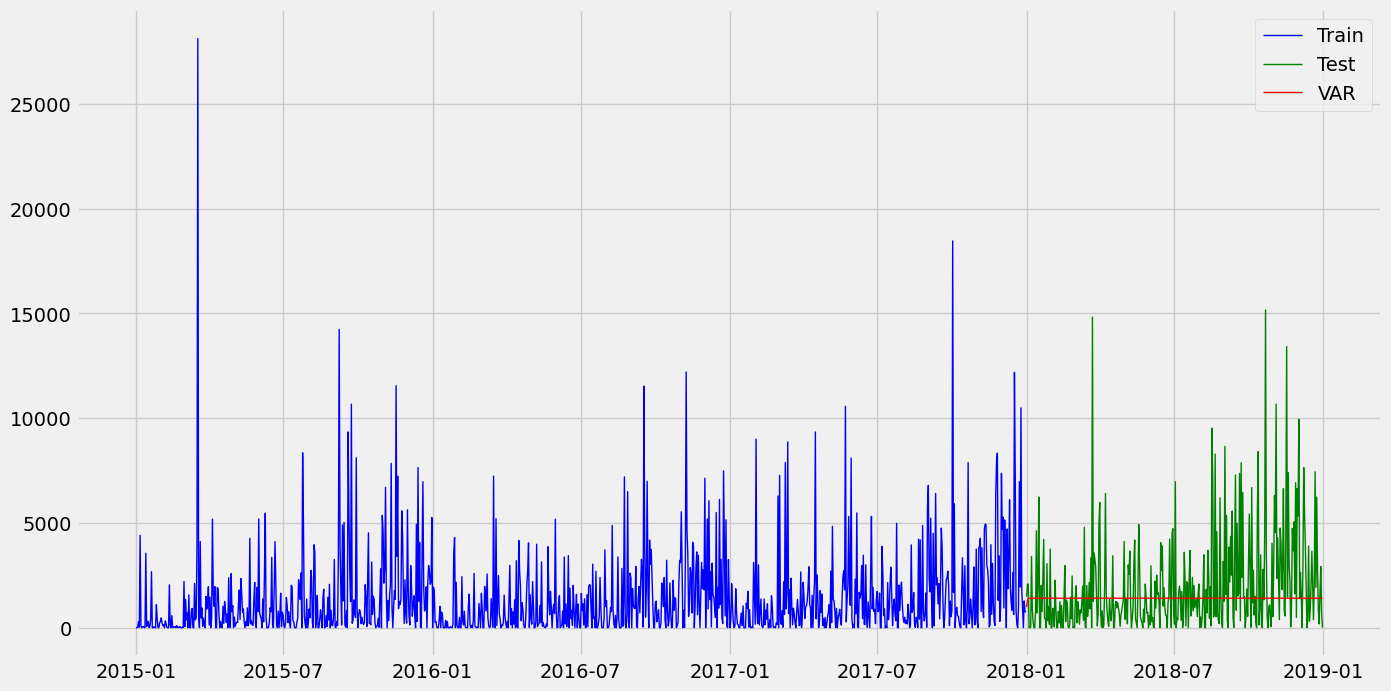

In [63]:
# Plot the VAR forecast and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='green', linewidth=1)
plt.plot(df_test['Order Date'], forecasted_df['Sales'], label='VAR', color='red', linewidth=1)
plt.legend()
plt.show()

In [64]:
print((61506/df_test['Sales'].sum())*100)

8.518222837759776


C:\Users\zive9\AppData\Local\Temp\ipykernel_19028\4022349104.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=df_errors, palette='plasma')


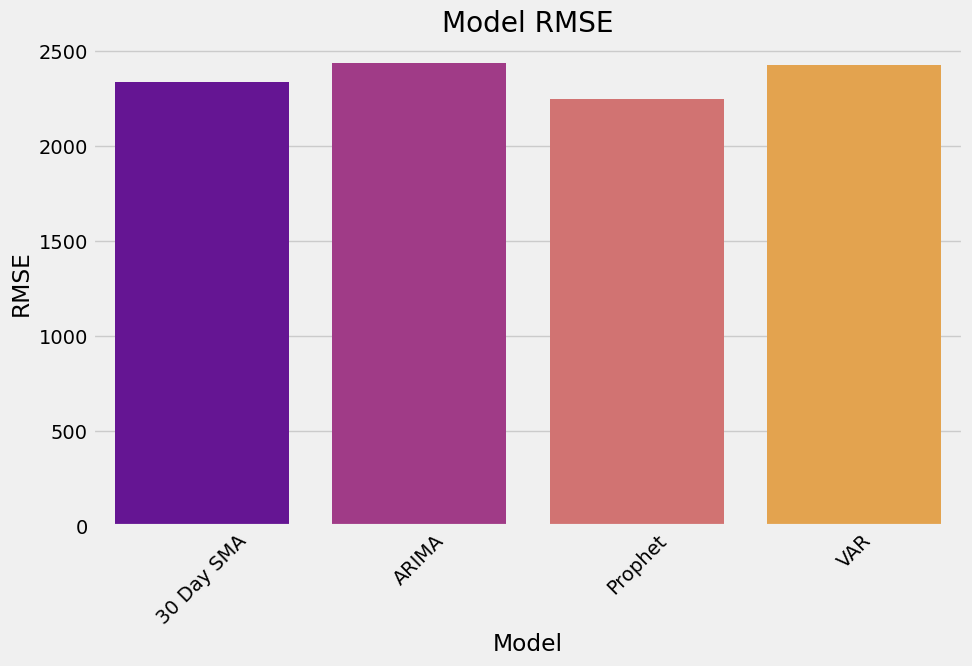

In [72]:
# Put all the errors into one dataframe 
df_errors = pd.DataFrame({
    'Model': ['30 Day SMA', 'ARIMA', 'Prophet', 'VAR'],
    'RMSE': [np.sqrt(mean_squared_error(df_test['Sales'], df_sma['SMA 30'].iloc[-365:])), 
             np.sqrt(mean_squared_error(df_test['Sales'], forecast_arima)), 
            # np.sqrt(mean_squared_error(df_sm_test['Sales'], forecast_sarima)),
             np.sqrt(mean_squared_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-365:])), 
             np.sqrt(mean_squared_error(df_var_test['Sales'], forecasted_df['Sales']))]
})

# Plot a bar chart of the errors with labels for each bar
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=df_errors, palette='plasma')
plt.title('Model RMSE')
plt.xticks(rotation=45)
plt.show()

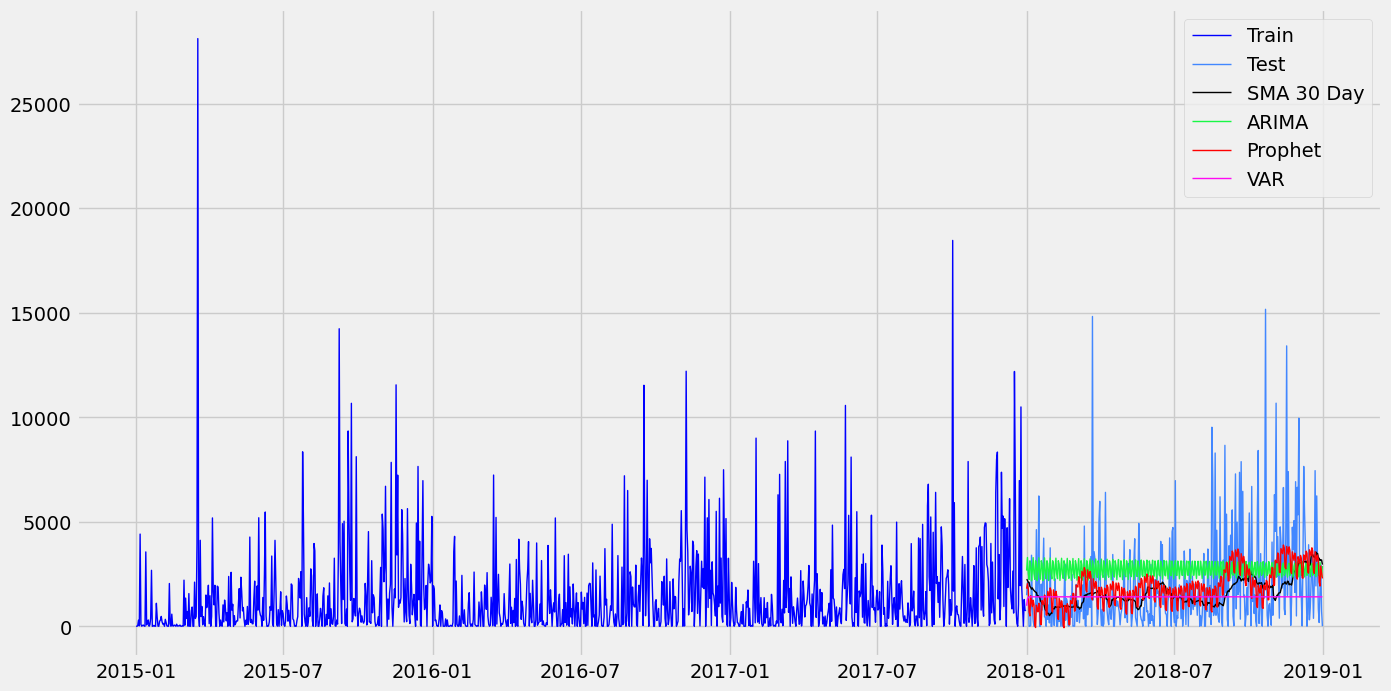

In [79]:
# Plot all the forecasts and the actual sales for 2018
plt.figure(figsize=(15, 8))
plt.plot(df_train['Order Date'], df_train['Sales'], label='Train', color='blue', linewidth=1)
plt.plot(df_test['Order Date'], df_test['Sales'], label='Test', color='#4287ff', linewidth=1)
plt.plot(df_test['Order Date'], df_sma['SMA 30'].iloc[-365:], label='SMA 30 Day', color='black', linewidth=1)
plt.plot(df_test['Order Date'], forecast_arima, label='ARIMA', color='#19f745', linewidth=1)
plt.plot(df_test['Order Date'], forecast_pt[-365:]['yhat'], label='Prophet', color='red', linewidth=1)
plt.plot(df_test['Order Date'], forecasted_df['Sales'], label='VAR', color='#ff0af3', linewidth=1)
plt.legend()
plt.show()

In [73]:
# Calculate the mean absolute percentage error for each model
sma_mape = mean_absolute_percentage_error(df_test['Sales'], df_sma['SMA 30'].iloc[-365:])
arima_mape = mean_absolute_percentage_error(df_test['Sales'], forecast_arima)
prophet_mape = mean_absolute_percentage_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-365:])
var_mape = mean_absolute_percentage_error(df_var_test['Sales'], forecasted_df['Sales'])

# Create a DataFrame with the MAPE for each model
df_mape = pd.DataFrame({
    'Model': ['30 Day SMA', 'ARIMA', 'Prophet', 'VAR'],
    'MAPE': [sma_mape, arima_mape, prophet_mape, var_mape]
})

df_mape['MAPE'] = df_mape['MAPE'].apply(lambda x: '{:.0f}'.format(x))
df_mape

,Model,MAPE
0,30 Day SMA,764451361414479232
1,ARIMA,1306926070290602752
2,Prophet,616954560367907584
3,VAR,746266182888418304


In [74]:
# Calculate the mean absolute error for each model
sma_mae = mean_absolute_error(df_test['Sales'], df_sma['SMA 30'].iloc[-365:])
arima_mae = mean_absolute_error(df_test['Sales'], forecast_arima)
prophet_mae = mean_absolute_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-365:])
var_mae = mean_absolute_error(df_var_test['Sales'], forecasted_df['Sales'])

# Create a DataFrame with the MAE for each model
df_mae = pd.DataFrame({
    'Model': ['30 Day SMA', 'ARIMA', 'Prophet', 'VAR'],
    'MAE': [sma_mae, arima_mae, prophet_mae, var_mae]
})

df_mae['MAE'] = df_mae['MAE'].apply(lambda x: '{:.0f}'.format(x))

df_mae


,Model,MAE
0,30 Day SMA,1569
1,ARIMA,1971
2,Prophet,1573
3,VAR,1585


In [82]:
# Calculate the percentage error for 2018
sma_pct = (df_sma['SMA 30'].iloc[-365:].sum() / df_test['Sales'].sum())
arima_pct = (forecast_arima.sum() / df_test['Sales'].sum())
prophet_pct = (forecast_pt['yhat'].iloc[-365:].sum() / df_pt_test['y'].sum())
var_pct = (forecasted_df['Sales'].sum() / df_var_test['Sales'].sum())

# Put the percentage errors in a dataframe
df_pct = pd.DataFrame({
    'Model': ['30 Day SMA', 'ARIMA', 'Prophet', 'VAR'],
    'pct': [sma_pct, arima_pct, prophet_pct, var_pct]
})

# df_pct['pct'] = df_pct['pct'].apply(lambda x: '{:.0f}'.format(x))

df_pct

,Model,pct
0,30 Day SMA,0.823538
1,ARIMA,1.373778
2,Prophet,0.971935
3,VAR,0.710329
